## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/ct-ch4-monthgrid-v2023_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes Data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

Surface methane (CH₄) emissions are derived from atmospheric measurements of methane and its ¹³C carbon isotope content. Different sources of methane contain different ratios of the two stable isotopologues, ¹²CH₄ and ¹³CH₄. This makes normally indistinguishable collocated sources of methane, say from agriculture and oil and gas exploration, distinguishable. The National Oceanic and Atmospheric Administration (NOAA) collects whole air samples from its global cooperative network of flasks (https://gml.noaa.gov/ccgg/about.html), which are then analyzed for methane and other trace gasses. A subset of those flasks are also analyzed for ¹³C of methane in collaboration with the Institute of Arctic and Alpine Research at the University of Colorado Boulder. Scientists at the National Aeronautics and Space Administration (NASA) and NOAA used those measurements of methane and ¹³C of methane in conjunction with a model of atmospheric circulation to estimate emissions of methane separated by three source types, microbial, fossil and pyrogenic.

For more information regarding this dataset, please visit the [CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes](https://earth.gov/ghgcenter/data-catalog/ct-ch4-monthgrid-v2023) data overview page.

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [53]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

## Querying the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [54]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes 
collection_name = "ct-ch4-monthgrid-v2023"

In [55]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac_client' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=ct-ch4-monthgrid-v2023>

In [56]:
# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For the case of the CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes v2023, the parameter of interest is “fossil”
# fossil = Fossil
asset_name = "fossil"

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 1998 to December 2021. By looking at the `dashboard:time density`, we observe that the data is periodic with monthly time density.

In [57]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 288 items


In [58]:
search = catalog.search(
    collections=collection_name,
    datetime=['2010-01-01T00:00:00Z','2010-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=ct-ch4-monthgrid-v2023-201012>
<Item id=ct-ch4-monthgrid-v2023-201011>
<Item id=ct-ch4-monthgrid-v2023-201010>
<Item id=ct-ch4-monthgrid-v2023-201009>
<Item id=ct-ch4-monthgrid-v2023-201008>
<Item id=ct-ch4-monthgrid-v2023-201007>
<Item id=ct-ch4-monthgrid-v2023-201006>
<Item id=ct-ch4-monthgrid-v2023-201005>
<Item id=ct-ch4-monthgrid-v2023-201004>
<Item id=ct-ch4-monthgrid-v2023-201003>
<Item id=ct-ch4-monthgrid-v2023-201002>
<Item id=ct-ch4-monthgrid-v2023-201001>


In [59]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=ct-ch4-monthgrid-v2023-202112>

## Visual Comparison Across Time Periods

You will now explore changes in the CH₄ flux at a given location and time. You will visualize the outputs on a map using `folium`.

In [60]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in the `rescale_values`.

In [62]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

color_map = "purd"

# To change the year and month of the observed parameter, you can modify the "items['YYYY-MM']" statement
# For example, you can change the current statement "items['2003-12']" to "items['2016-10']" 

observation_date_1 = items["2016-12"]

# Extract collection name and item ID
collection_id = observation_date_1.collection_id
item_id = observation_date_1.id

In [63]:
object = observation_date_1.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max")-400,
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)


{'max': 57.88093084144856, 'min': 0.0}


Now, you will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. This step is done twice so that you can visualize two arbitrary events independently.

In [64]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "purd"

# Make a GET request to retrieve information for the date mentioned below
observation_date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_1_tile


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/ct-ch4-monthgrid-v2023/items/ct-ch4-monthgrid-v2023-201612/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C57.88093084144856'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [65]:
# Make a GET request to retrieve information for the date mentioned below
observation_date_2 = items["1999-01"]
# Extract collection name and item ID
collection_id = observation_date_2.collection_id
item_id = observation_date_2.id

observation_date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/ct-ch4-monthgrid-v2023/items/ct-ch4-monthgrid-v2023-199901/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C57.88093084144856'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Map Out Selected Tiles
For this study, you are going to compare the CO₂ levels for Amazon Rainforest, South America.

In [66]:
# The Area of Interest (AOI) is set to Amazon Rainforest, South America
amazon_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-74.0, -3.0],   # Southwest Bounding Coordinate
                [-74.0, 5.0],    # Southeast Bounding Coordinate
                [-60.0, 5.0],    # Northeast Bounding Coordinate
                [-60.0, -3.0],   # Northwest Bounding Coordinate
                [-74.0, -3.0]    # Closing the polygon at the Southwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


In [67]:
# For this study we are going to compare the NPP level for observation_date_1 and observation_date_2 over the Amazon Rainforest, South America 
# To change the location, you can simply insert the latitude and longitude of the area of your interest in the "location=(LAT, LONG)" statement
# For example, you can change the current statement "location=(0, -66)" to "location=(34, -118)" to monitor the NPP level in California instead of Amazon Rainforest, South America

# Set initial zoom and center of map for CO₂ Layer
# 'folium.plugins' allows mapping side-by-side
map_ = folium.plugins.DualMap(location=(0, -66), zoom_start=5)


# Define the first map layer with NPP level for the tile fetched for date 1
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_observation_date_1 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the first layer to the Dual Map
map_layer_observation_date_1.add_to(map_.m1)


# Define the first map layer with NPP level for the tile fetched for date 2
map_layer_observation_date_2 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)

# Add the second layer to the Dual Map
map_layer_observation_date_2.add_to(map_.m2)

# Display data markers (titles) on both maps
folium.GeoJson(amazon_aoi, name="Amazon Rainforest, South America").add_to(map_)

# Visualize the Dual Map
map_

# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Amazon Rainforest, South America.

Before we generate stats for a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [44]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 288 items


In [ ]:
# Examine the first item in the collection
items[0]

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [46]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"][:10],
    }

In [47]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"][:10])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2021-12-01


Generate the statistics for the AOI

In [ ]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, texas_aoi) for item in items]

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [50]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.042764596042364544,
   'max': 45.46200998420616,
   'mean': 9.320847132019729,
   'count': 36.0,
   'sum': 335.5504967527103,
   'std': 11.191973503272377,
   'median': 5.158028075849703,
   'majority': 0.042764596042364544,
   'minority': 0.042764596042364544,
   'unique': 36.0,
   'histogram': [[17.0, 7.0, 4.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0, 1.0],
    [0.042764596042364544,
     4.584689134858745,
     9.126613673675124,
     13.668538212491503,
     18.210462751307883,
     22.752387290124265,
     27.294311828940643,
     31.83623636775702,
     36.378160906573406,
     40.92008544538979,
     45.46200998420616]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 36.0,
   'percentile_2': 0.042764596042364544,
   'percentile_98': 45.46200998420616}},
 'datetime': '2021-12-01'}

In [51]:
# Create a function that converts statistics in JSON format into a pandas DataFrame
def clean_stats(stats_json) -> pd.DataFrame:

    # Normalize the JSON data
    df = pd.json_normalize(stats_json)

    # Replace the naming "statistics.b1" in the columns
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]

    # Set the datetime format
    df["date"] = pd.to_datetime(df["datetime"])

    # Return the cleaned format
    return df

# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-12-01,0.042765,45.462010,9.320847,36.0,335.550497,11.191974,5.158028,0.042765,0.042765,36.0,"[[17.0, 7.0, 4.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.042765,45.462010,2021-12-01
1,2021-11-01,0.044964,47.792656,9.881737,36.0,355.742547,11.811206,5.539923,0.044964,0.044964,36.0,"[[17.0, 7.0, 4.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.044964,47.792656,2021-11-01
2,2021-10-01,0.047354,50.748007,10.482134,36.0,377.356828,12.544851,5.875716,0.047354,0.047354,36.0,"[[17.0, 8.0, 3.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.047354,50.748007,2021-10-01
3,2021-09-01,0.049785,53.757997,11.038499,36.0,397.385968,13.261091,6.160318,0.049785,0.049785,36.0,"[[17.0, 8.0, 3.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.049785,53.757997,2021-09-01
4,2021-08-01,0.051317,55.694603,11.387665,36.0,409.955938,13.717379,6.337174,0.051317,0.051317,36.0,"[[17.0, 8.0, 3.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0...",100.0,0.0,36.0,0.051317,55.694603,2021-08-01


## Time-Series Analysis
You can now explore the fossil fuel emission using this data collection (January 1998 -December 2021) for the Amazon Rainforest, South America region. You can plot the data set using the code below:

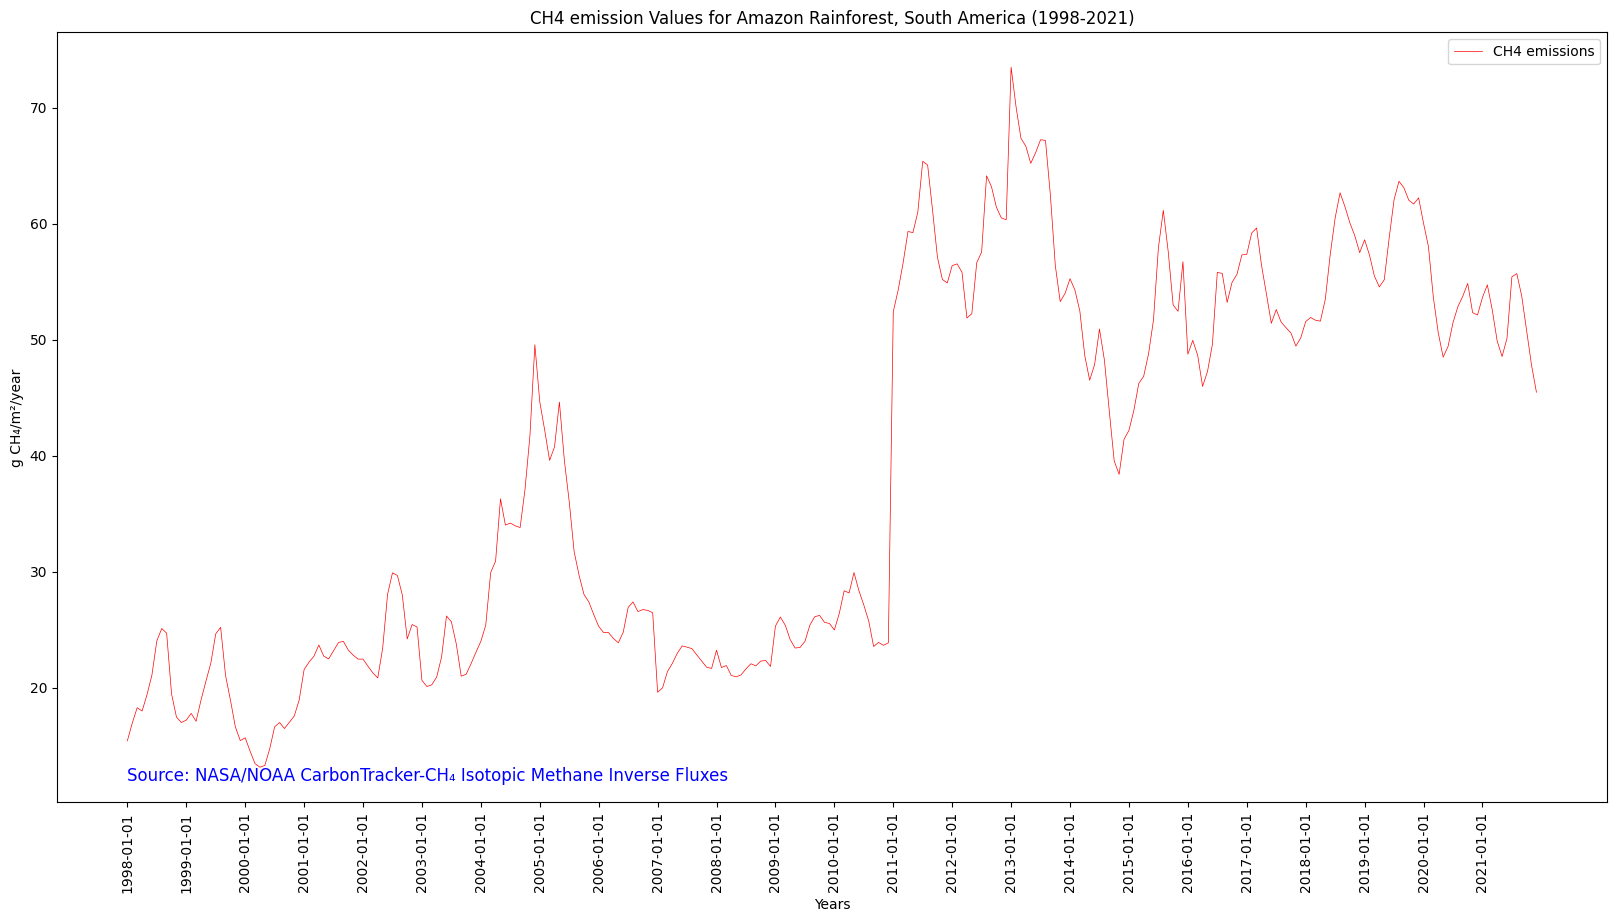

In [52]:
# Figure size: 20 representing the width, 10 representing the height
df = df.sort_values(by="datetime")
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CH4 flux
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CH4 emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("g CH₄/m²/year")
plt.xticks(rotation = 90)

interval = 12
ticks = range(0, len(df), interval)  # Tick positions
plt.xticks(ticks, df["datetime"].iloc[ticks])  # Use the corresponding datetime values


# Insert title for the plot
plt.title("CH4 emission Values for Amazon Rainforest, South America (1998-2021)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df["max"].min(),                  # Y-coordinate of the text

    # Text to be displayed
    "Source: NASA/NOAA CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes",                  
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes dataset:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the CH₄ inverse fluxes levels over the Amazon Rainforest, South America area for two distinctive months/years
5.	Create a table that displays the minimum, maximum, and sum of the CH₄ Inverse Flux values for a specified region
6.	Generate a time-series graph of the CH₄ Inverse Flux values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 